In this version, let's suppose the pixels id are already mapped (top left corner for pixel 0)

In [123]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

nexus_file = "/SNS/VENUS/IPTS-34969/nexus/VENUS_7703.nxs.h5"
profile_width = 10
list_pixel_to_exclude = set()

with h5py.File(nexus_file, 'r') as hdf5_data:
    event_time_offset_original = hdf5_data['entry']['bank100_events']['event_time_offset'][:]
    event_id_original = hdf5_data['entry']['bank100_events']['event_id'][:]

offset_value = 1000000  # Offset value
event_id_original -= offset_value

# DEBUGGING: Work with only the first n events
# n_events = min(len(event_time_offset_original), 300000000)
# event_time_offset = event_time_offset_original[:n_events]
# event_id = event_id_original[:n_events]
event_id = event_id_original

# hist, bin_edges = np.histogram(event_time_offset, bins=1000, range=(0, 16667))

# Vectorized mapping function
def map_pixels_to_coordinates(pixel_ids):
    rows = pixel_ids % 512
    cols = pixel_ids // 512
    return rows, cols

# Initialize the full image
full_image = np.zeros((512, 512), dtype=np.int32)

# Vectorized processing
rows, cols = map_pixels_to_coordinates(event_id)
np.add.at(full_image, (cols, rows), 1)



In [160]:
def find_first_above_threshold(profile, threshold):
    for index, value in enumerate(profile):
        if value >= threshold:
            return index
    return -1  # Return -1 if no value is above the threshold

def find_last_above_threshold(profile, threshold):
    for index, value in enumerate(profile[::-1]):
        if value >= threshold:
            return len(profile) - index - 1
    return -1  # Return -1 if no value is above the threshold
# # Example usage
# profile = np.array([0, 0, 0, 0, 10, 20, 30, 30, 20, 5, 0, 0, 0])
# threshold = 10
# first_index = find_first_above_threshold(profile, threshold)
# last_index = find_last_above_threshold(profile, threshold)
# print("First index above threshold:", first_index)
# print("Last index above threshold:", last_index)

def display_analysis(full_image=None, 
                     verti_from_xy=None, 
                     verti_to_xy=None, 
                     verti_region_of_constant_intensity=None,
                     hori_from_xy=None, 
                     hori_to_xy=None, hori_region_of_constant_intensity=None,
                     theory_box_coordinates=None, zoom=None,
                     title=None,
                     list_pixel_to_exclude=None):
    
    if full_image is None:
        raise ValueError("full_image must be provided")
    if verti_from_xy is None or verti_to_xy is None:
        raise ValueError("verti_from_xy and verti_to_xy must be provided")
    if hori_from_xy is None or hori_to_xy is None:
        raise ValueError("hori_from_xy and hori_to_xy must be provided")
    if theory_box_coordinates is None:
        raise ValueError("theory_box_coordinates must be provided")
    if zoom is None:
        raise ValueError("zoom must be provided")

    # Plot the result
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    im= axs[0].imshow(full_image, cmap='viridis', interpolation='nearest')
    plt.colorbar(im, shrink=0.8, ax=axs[0])
    # display line from_xy to to_xy
    axs[0].plot([verti_from_xy[0], verti_to_xy[0]], [verti_from_xy[1], verti_to_xy[1]], 'r-', lw=2)
    axs[0].plot([hori_from_xy[0], hori_to_xy[0]], [hori_from_xy[1], hori_to_xy[1]], 'b-', lw=2)

    # zoom to region of interest
    axs[0].set_xlim(zoom[0], zoom[1])
    axs[0].set_ylim(zoom[2], zoom[3])  # Invert y-axis
    # invert y-axis
    axs[0].invert_yaxis()
    axs[0].set_title(title)

    verti_profile = np.mean(full_image[verti_from_xy[1]:verti_to_xy[1], verti_from_xy[0]-profile_width//2:verti_to_xy[0]+profile_width//2+1], axis=1)
    mean_value = np.mean(full_image[verti_region_of_constant_intensity[0]: verti_region_of_constant_intensity[1], 
                                    verti_from_xy[0]-profile_width//2:verti_to_xy[0]+profile_width//2+1])
    min_value = np.min(np.mean(full_image[verti_region_of_constant_intensity[0]: verti_region_of_constant_intensity[1], 
                                    verti_from_xy[0]-profile_width//2:verti_to_xy[0]+profile_width//2+1], axis=1))
    # find the first index where the profile is less than the min value
    first_useful_vertical_pixel = find_first_above_threshold(verti_profile, min_value)
    # find the last index where the profile is less than the min value
    last_useful_vertical_pixel = find_last_above_threshold(verti_profile, min_value)
    axs[1].plot(verti_profile, 'r.')  # Assuming you want to plot the profile on axs[1]
    axs[1].set_title(f'vertical profile (exp mask from {verti_from_xy[1] + first_useful_vertical_pixel} to {verti_from_xy[1] + last_useful_vertical_pixel})')
    axs[1].set_xticks(range(0, verti_profile.shape[0], 10))
    axs[1].set_xticklabels(range(verti_from_xy[1], verti_to_xy[1], 10))
    axs[1].axhline(mean_value, color='green', linestyle='--', label='Mean Value')
    axs[1].axhline(min_value, color='red', linestyle='--', label='Min Value')
    axs[1].axvline(first_useful_vertical_pixel, color='blue', linestyle='--', label='First Useful Pixel')
    axs[1].axvline(last_useful_vertical_pixel, color='orange', linestyle='--', label='Last Useful Pixel')
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    axs[1].legend()

    hori_profile = np.mean(full_image[hori_from_xy[1] - profile_width//2: hori_to_xy[1] + profile_width//2 + 1, 
                                    hori_from_xy[0]:hori_to_xy[0]], axis=0)
    mean_value = np.mean(full_image[hori_from_xy[1] - profile_width//2: hori_to_xy[1] + profile_width//2 + 1, 
                                    hori_region_of_constant_intensity[0]: hori_region_of_constant_intensity[1]])
    min_value = np.min(np.mean(full_image[hori_from_xy[1] - profile_width//2: hori_to_xy[1] + profile_width//2 + 1, 
                                    hori_region_of_constant_intensity[0]: hori_region_of_constant_intensity[1]], axis=0))
    # find the first index where the profile is less than the min value
    first_useful_horizontal_pixel = find_first_above_threshold(hori_profile, min_value) 
    # find the last index where the profile is less than the min value
    last_useful_horizontal_pixel = find_last_above_threshold(hori_profile, min_value)
    axs[2].plot(hori_profile, 'b.')  # Assuming you want to plot the profile on axs[2]
    axs[2].set_title(f'horizontal profile (exp mask from {first_useful_horizontal_pixel} to {last_useful_horizontal_pixel})')
    axs[2].set_xticks(range(0, hori_profile.shape[0], 10))
    axs[2].set_xticklabels(range(hori_from_xy[0], hori_to_xy[0], 10))
    axs[2].axhline(min_value, color='red', linestyle='--', label='Min Value')
    axs[2].axhline(mean_value, color='green', linestyle='--', label='Mean Value')
    axs[2].axvline(first_useful_horizontal_pixel, color='blue', linestyle='--', label='First Useful Pixel')
    axs[2].axvline(last_useful_horizontal_pixel, color='orange', linestyle='--', label='Last Useful Pixel')
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    axs[2].legend()

    # plot theory box region (rectangle)
    axs[0].add_patch(plt.Rectangle((theory_box_coordinates[0][0], theory_box_coordinates[0][1]),
                                    theory_box_coordinates[1][0] - theory_box_coordinates[0][0],
                                    theory_box_coordinates[1][1] - theory_box_coordinates[0][1],
                                    fill=False, edgecolor='green', lw=2))

    # display edges of the experimental mask
    exp_top_pixel = first_useful_vertical_pixel + verti_from_xy[1]
    exp_bottom_pixel = last_useful_vertical_pixel + verti_from_xy[1]
    exp_left_pixel = first_useful_horizontal_pixel + hori_from_xy[0]
    exp_right_pixel = last_useful_horizontal_pixel + hori_from_xy[0]
    axs[0].add_patch(plt.Rectangle((exp_left_pixel, exp_top_pixel),
                                        exp_right_pixel - exp_left_pixel,
                                        exp_bottom_pixel - exp_top_pixel,
                                    fill=False, edgecolor='blue', linestyle='--', lw=2))

    plt.tight_layout()
    plt.show()

    print("First useful vertical pixel:", exp_top_pixel)
    print("Last useful vertical pixel:", exp_bottom_pixel)
    print("First useful horizontal pixel:", exp_left_pixel)
    print("Last useful horizontal pixel:", exp_right_pixel)

    return {'exp_left_pixel': exp_left_pixel, 'exp_right_pixel': exp_right_pixel,
            'exp_top_pixel': exp_top_pixel, 'exp_bottom_pixel': exp_bottom_pixel}

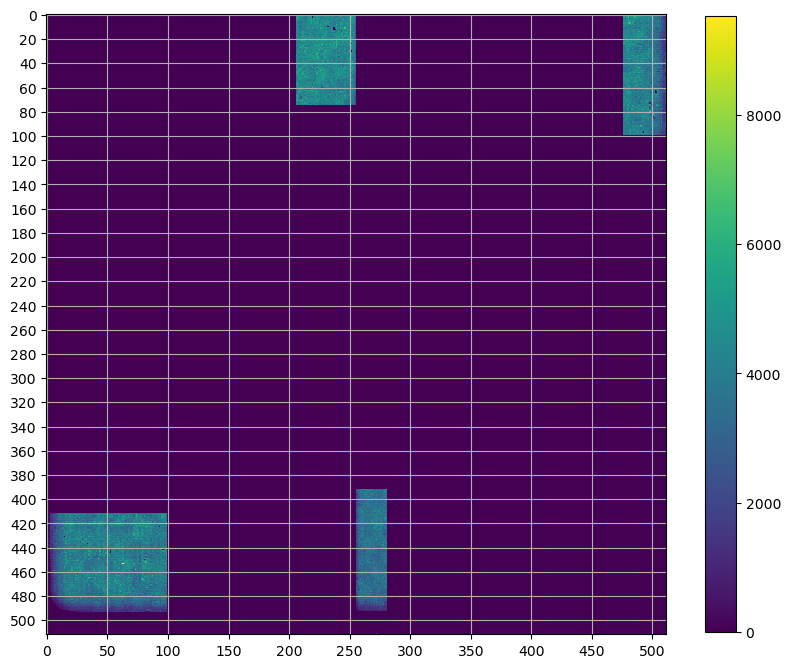

In [161]:
# Plot the result
plt.figure(0, figsize=(10, 10))
im= plt.imshow(full_image, cmap='viridis', interpolation='nearest')
plt.colorbar(im, shrink=0.8)
# display finner grid
plt.xticks(np.arange(0, 512, 50))
plt.yticks(np.arange(0, 512, 20))
plt.grid(which='both')
plt.show()

In [ ]:
# # profile to find bottom left box edges
# # vertical profile
# verti_from_xy = [500, 0]
# verti_to_xy = [500, 120]
# verti_region_of_constant_intensity = [10, 100] 

# # horizontal profile
# hori_from_xy = [450, 50]
# hori_to_xy = [512, 50]
# hori_region_of_constant_intensity = [460, 500] # x,y

# # theory box coordinates (Kevin's box)
# theory_box_coordinates = ([476, 0], [511, 100]) # x, y

# # zoom to focus on region of interest
# zoom = [460, 511, 0, 110]  # [x_min, x_max, y_min, y_max]

# bottom left corner

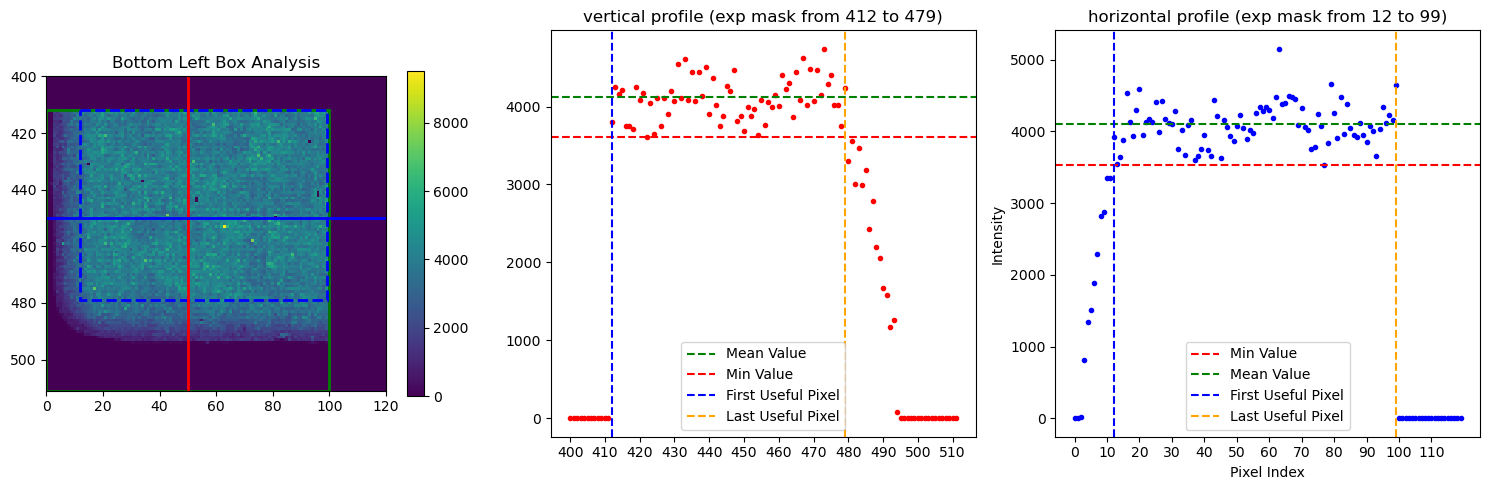

First useful vertical pixel: 412
Last useful vertical pixel: 479
First useful horizontal pixel: 12
Last useful horizontal pixel: 99


In [164]:
# profile to find bottom left box edges
# vertical profile
verti_from_xy = [50, 400]
verti_to_xy = [50, 512]
verti_region_of_constant_intensity = [420, 480] 

# horizontal profile
hori_from_xy = [0, 450]
hori_to_xy = [120, 450]
hori_region_of_constant_intensity = [20, 95] # x,y

# theory box coordinates (Kevin's box)
theory_box_coordinates = ([0, 412], [100, 511])

# zoom to focus on region of interest
zoom = [0, 120, 400, 511]  # [x_min, x_max, y_min, y_max]

region = display_analysis(full_image=full_image,
                 verti_from_xy=verti_from_xy,
                 verti_to_xy=verti_to_xy,
                 verti_region_of_constant_intensity=verti_region_of_constant_intensity,
                 hori_from_xy=hori_from_xy,
                 hori_to_xy=hori_to_xy,
                 hori_region_of_constant_intensity=hori_region_of_constant_intensity,
                 theory_box_coordinates=theory_box_coordinates,
                 zoom=zoom,
                 title="Bottom Left Box Analysis")

exp_left_pixel = region['exp_left_pixel']
exp_right_pixel = region['exp_right_pixel']
exp_top_pixel = region['exp_top_pixel']
exp_bottom_pixel = region['exp_bottom_pixel']

# left column
for _x in range(0, exp_left_pixel):
    for _y in range(0, 512):
        list_pixel_to_exclude.add((_x, _y))

# bottom part
for _x in range(0, 512):
    for _y in range(exp_bottom_pixel, 512):
        list_pixel_to_exclude.add((_x, _y))


# Bottom center 

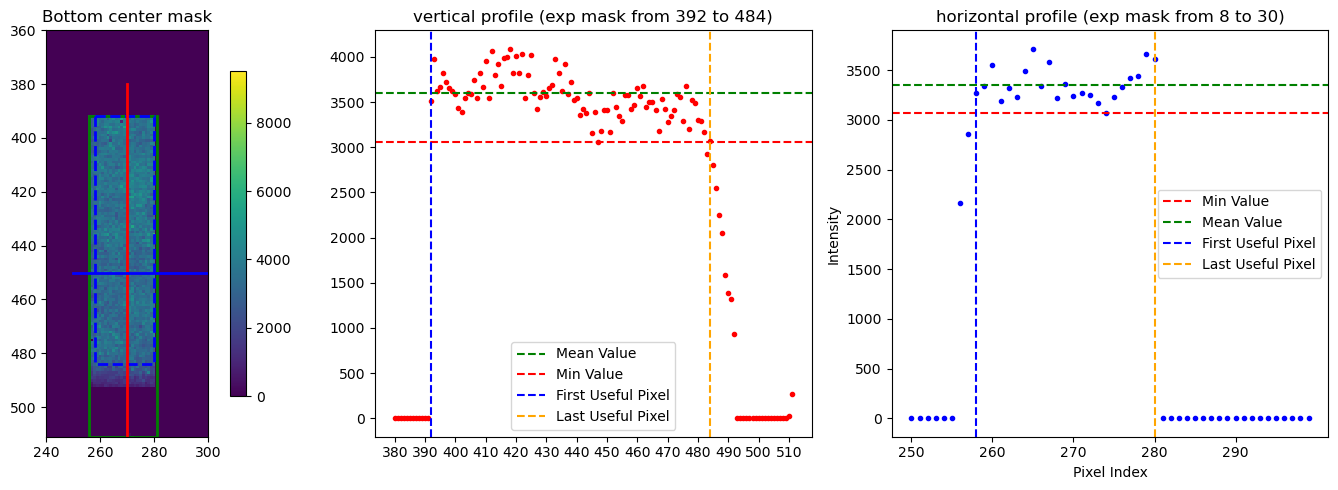

First useful vertical pixel: 392
Last useful vertical pixel: 280
First useful horizontal pixel: 258
Last useful horizontal pixel: 280


In [149]:
verti_from_xy = (270, 380)  # (x, y)
verti_to_xy = (270, 512)  # (x, y)
verti_region_of_constant_intensity = (400, 470)  # (x, y)

hori_from_xy = (250, 450)  # (x, y)
hori_to_xy = (300, 450)  # (x, y)
hori_region_of_constant_intensity = (265, 280)  # (x, y)

theory_box_coordinates = ((256, 392), (281, 511))

zoom = [240, 300, 360, 511]  # [x_min, x_max, y_min, y_max]

title = "Bottom center mask"

region = display_analysis(full_image=full_image,
                 verti_from_xy=verti_from_xy,
                 verti_to_xy=verti_to_xy,
                 verti_region_of_constant_intensity=verti_region_of_constant_intensity,
                 hori_from_xy=hori_from_xy,
                 hori_to_xy=hori_to_xy,
                 hori_region_of_constant_intensity=hori_region_of_constant_intensity,
                 theory_box_coordinates=theory_box_coordinates,
                 zoom=zoom,
                 title=title)

# top right mask

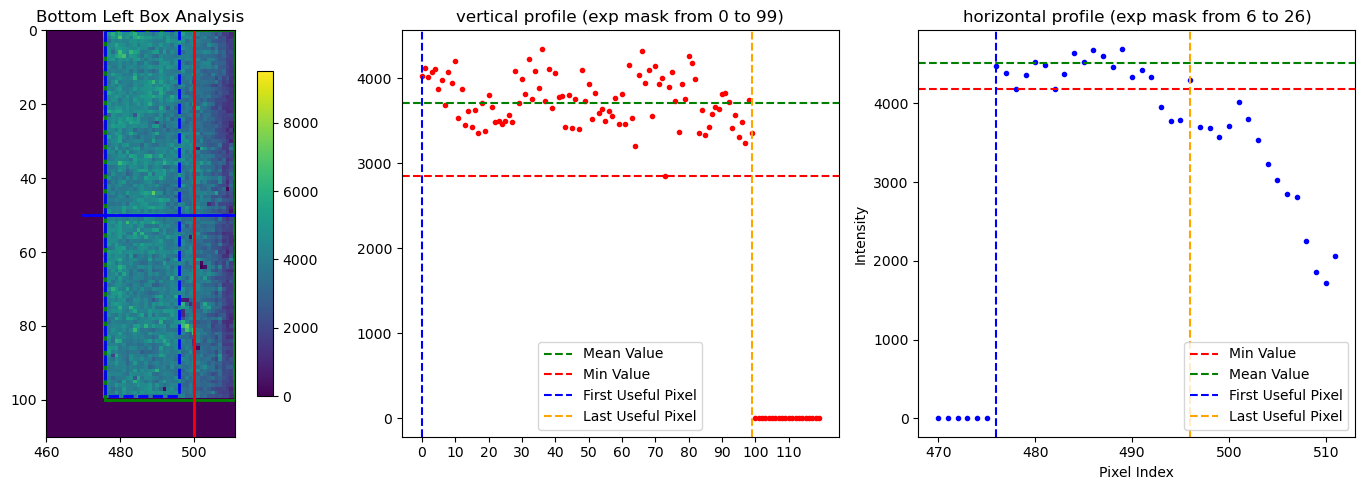

First useful vertical pixel: 0
Last useful vertical pixel: 99
First useful horizontal pixel: 476
Last useful horizontal pixel: 496


In [165]:
# profile to find bottom left box edges
# vertical profile
verti_from_xy = [500, 0]
verti_to_xy = [500, 120]
verti_region_of_constant_intensity = [10, 100] 

# horizontal profile
hori_from_xy = [470, 50]
hori_to_xy = [512, 50]
hori_region_of_constant_intensity = [480, 490] # x,y

# theory box coordinates (Kevin's box)
theory_box_coordinates = ([476, 0], [511, 100]) # x, y

# zoom to focus on region of interest
zoom = [460, 511, 0, 110]  # [x_min, x_max, y_min, y_max]

title = "top right corner"

region = display_analysis(full_image=full_image,
                 verti_from_xy=verti_from_xy,
                 verti_to_xy=verti_to_xy,
                 verti_region_of_constant_intensity=verti_region_of_constant_intensity,
                 hori_from_xy=hori_from_xy,
                 hori_to_xy=hori_to_xy,
                 hori_region_of_constant_intensity=hori_region_of_constant_intensity,
                 theory_box_coordinates=theory_box_coordinates,
                 zoom=zoom,
                 title="Bottom Left Box Analysis")

exp_left_pixel = region['exp_left_pixel']
exp_right_pixel = region['exp_right_pixel']
exp_top_pixel = region['exp_top_pixel']
exp_bottom_pixel = region['exp_bottom_pixel']

for _x in range(exp_right_pixel, 512):
    for _y in range(0, 512):
        list_pixel_to_exclude.add((_x, _y))

# Display full mask

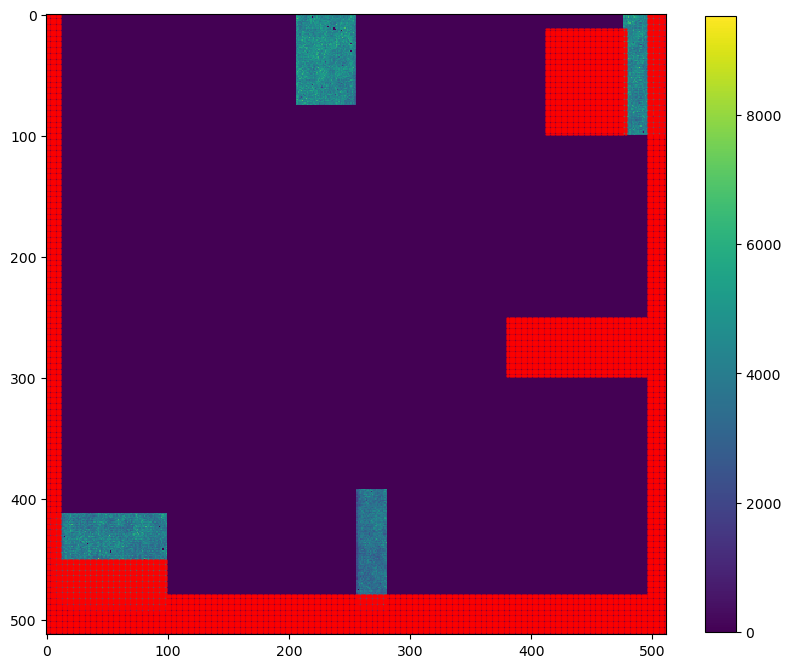

In [167]:
# display full mask (all the pixels we shouldn't use)
plt.figure(0, figsize=(10, 10))
im= plt.imshow(full_image, cmap='viridis', interpolation='nearest')
plt.colorbar(im, shrink=0.8)

for _x, _y in list_pixel_to_exclude:
    plt.plot(_x, _y, 'r.', markersize=1)